# Drought Analysis at State Scale

This code was created to calculate the slope and perform our drought analysis on the statewide scale using all available wells.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine:

In [44]:
# Packages and paths

import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr

# Local paths
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'

# Function to calculate slope using linear regression
def calculate_slope(y):
    x = np.arange(len(y))
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Functions for correlations
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [45]:
# ==== Reading in the data ====
# Importing GRACE analyses
filepath = filepath = outputpath+'/grace_stateavg_yearly.csv'
grace_yearly = pd.read_csv(filepath, index_col=0)
grace_yearly = grace_yearly[:-1]
print("GRACE data loaded.")

# Read in the annual time series database
filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filepath = os.path.join(outputpath, filename_ts)
annual_db = pd.read_csv(filepath, header=1, index_col=0)
print("Well data loaded.")

annual_db = annual_db[1:168102]
annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2 = annual_db2.set_index('Combo_ID')
annual_db2.head()
print("Well data formatted.")

# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv') #this version doesn't have PHDI so adjust accordingly
drought_indices = drought_indices.set_index('In_year')
print("Drought data loaded and formatted.")

GRACE data loaded.
Well data loaded.
Well data formatted.
Drought data loaded and formatted.


Creating Colors

In [79]:
# %% Creating colors

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

grace_color = '#A92B2A'
# az_wells_color = '#1D4E77'
az_wells_color = 'black'

Establishing Drought Years

In [80]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [81]:
yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]

Setting up the analysis period

In [82]:
minyear = 2002 # Year GRACE was launched
maxyear = 2023

# %% Figure out which water level database you want
cat_wl2 = grace_yearly.copy() 

# Water Analysis period
wlanalysis_period_grace = cat_wl2[(cat_wl2.index>=minyear)&(cat_wl2.index<=maxyear)]

In [83]:
# Enter min year and max year of timeframe
minyear = 2000 # When Lakemead started to go into drought

# %% Figure out which water level database you want
cat_wl2 = annual_db2.copy()
cat_wl2 = cat_wl2.transpose()
cat_wl2 = cat_wl2.reset_index()
cat_wl2['index'] = pd.to_numeric(cat_wl2['index'], errors='coerce')
cat_wl2.index = cat_wl2.index.astype('int64')
cat_wl2 = cat_wl2.set_index('index')

# Water Analysis period for wells
wlanalysis_period_AZwells = cat_wl2[(cat_wl2.index>=minyear)&(cat_wl2.index<=maxyear)]
wlanalysis_period_AZwells.head()

Combo_ID,83578,84067,84442,84455,84460,84598,84614,84626,84630,84633,...,364515111034001,364528113101401,364529109292701,364537109390801,364550112401201,364552109315901,364613109510801,364614114054601,364619114054801,364625113595501
index,,,,,,,,,,,,,,,,,,,,,
2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-36.8,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# Calculate the mean across columns for each row
average_per_year = wlanalysis_period_AZwells.mean(axis=1)

# Create a new DataFrame with years as rows and an 'Average' column
average_df_AZ = pd.DataFrame(average_per_year)

# Display the resulting DataFrame
average_df_AZ

,0
index,
2000.0,203.642425
2001.0,206.210629
2002.0,214.843555
2003.0,214.888602
2004.0,208.806658
2005.0,212.319045
2006.0,216.104375
2007.0,210.245992
2008.0,181.652543


In [85]:
# Narrowing the drought indices to be during our study period
drought_indices_wells = drought_indices[(drought_indices.index>=minyear)&(drought_indices.index<=maxyear)]
drought_indices_grace = drought_indices[(drought_indices.index>=2002)&(drought_indices.index<=maxyear)]

For comparing to drought indices

In [86]:
ds = wlanalysis_period_grace
drought = drought_indices_grace
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print("Results for GRACE:")
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Results for GRACE:
Kendall Correlation coefficient
 0:
  tau =  -0.065
  pval =  0.6964
Spearman Correlation coefficient
 0:
  rho =  -0.066
  pval =  0.7702
Pearson Correlation coefficient
 0:
  rsq =  0.007
  pval =  0.7202


In [87]:
ds = average_df_AZ
drought = drought_indices_wells
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print("Results for State Wells:")
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Results for State Wells:
Kendall Correlation coefficient
 0:
  tau =  -0.065
  pval =  0.6765
Spearman Correlation coefficient
 0:
  rho =  -0.131
  pval =  0.5408
Pearson Correlation coefficient
 0:
  rsq =  0.004
  pval =  0.7589


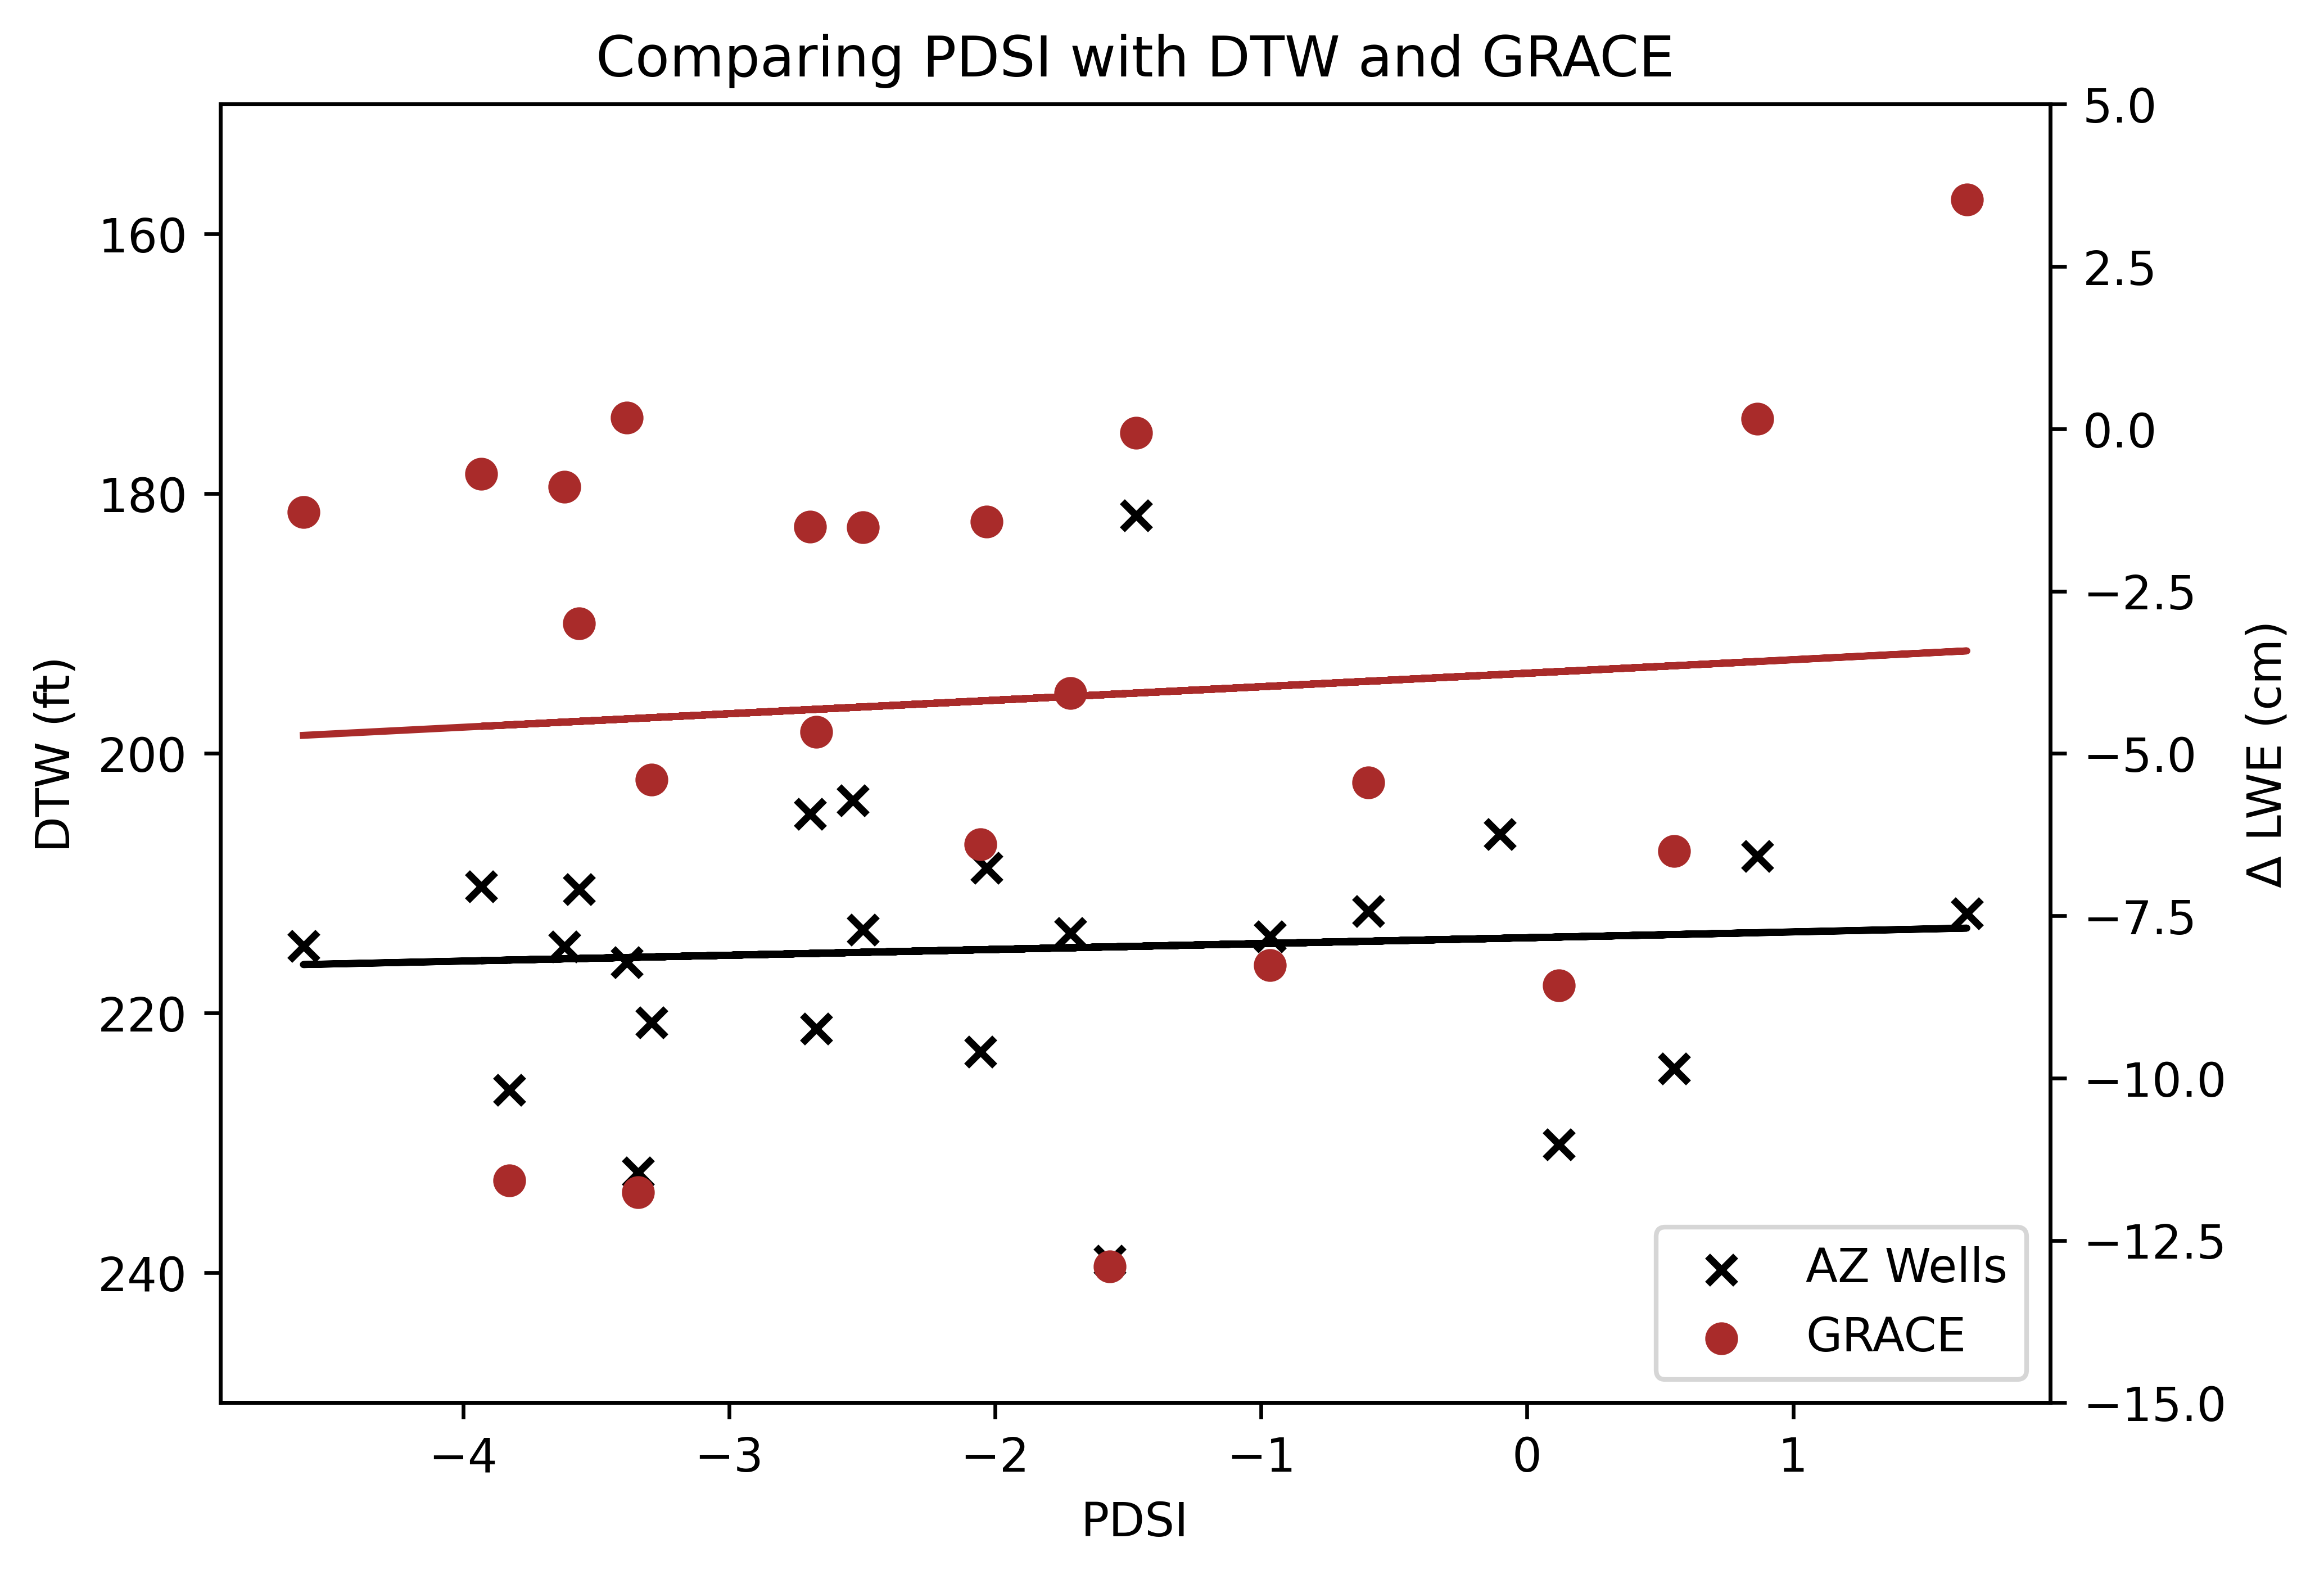

In [94]:
# %% Scatterplot of correlation values
ds = wlanalysis_period_grace
ds2 = average_df_AZ
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
ax.set_ylim(250,150)
ax2.set_ylim(-15,5)

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

For Calculating Anomlies

In [95]:
# Anomaly's
ds = wlanalysis_period_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period_grace.copy()
dtw_anomalys_grace = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (wlanalysis_period_grace.index*slope) + intercept
        dtw_anomalys_grace[i] = wlanalysis_period_grace[i] - trend_df[i]
        

dtw_anomalys_grace.head()

,0
year,
2002,-3.324850
2003,-2.343840
2004,-2.291184
2005,3.269064
2006,0.499755


In [96]:
# Anomaly's
ds = average_df_AZ.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = average_df_AZ.copy()
dtw_anomalys_AZ = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (average_df_AZ.index*slope) + intercept
        dtw_anomalys_AZ[i] = average_df_AZ[i] - trend_df[i]
        

dtw_anomalys_AZ.head()

,0
index,
2000.0,0.600256
2001.0,2.121814
2002.0,9.708095
2003.0,8.706496
2004.0,1.577907


In [97]:
ds = dtw_anomalys_grace
drought = drought_indices_grace
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print('GRACE Az Anomaly Correlation Results:')
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

GRACE Az Anomaly Correlation Results:
Kendall Correlation coefficient
 0:
  tau =  0.463
  pval =  0.0021
Spearman Correlation coefficient
 0:
  rho =  0.614
  pval =  0.0024
Pearson Correlation coefficient
 0:
  rsq =  0.398
  pval =  0.0016


In [98]:
ds = dtw_anomalys_AZ
drought = drought_indices_wells
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print('Depth To Water Anomaly Correlation Results:')
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Depth To Water Anomaly Correlation Results:
Kendall Correlation coefficient
 0:
  tau =  -0.167
  pval =  0.2675
Spearman Correlation coefficient
 0:
  rho =  -0.251
  pval =  0.2362
Pearson Correlation coefficient
 0:
  rsq =  0.051
  pval =  0.2885


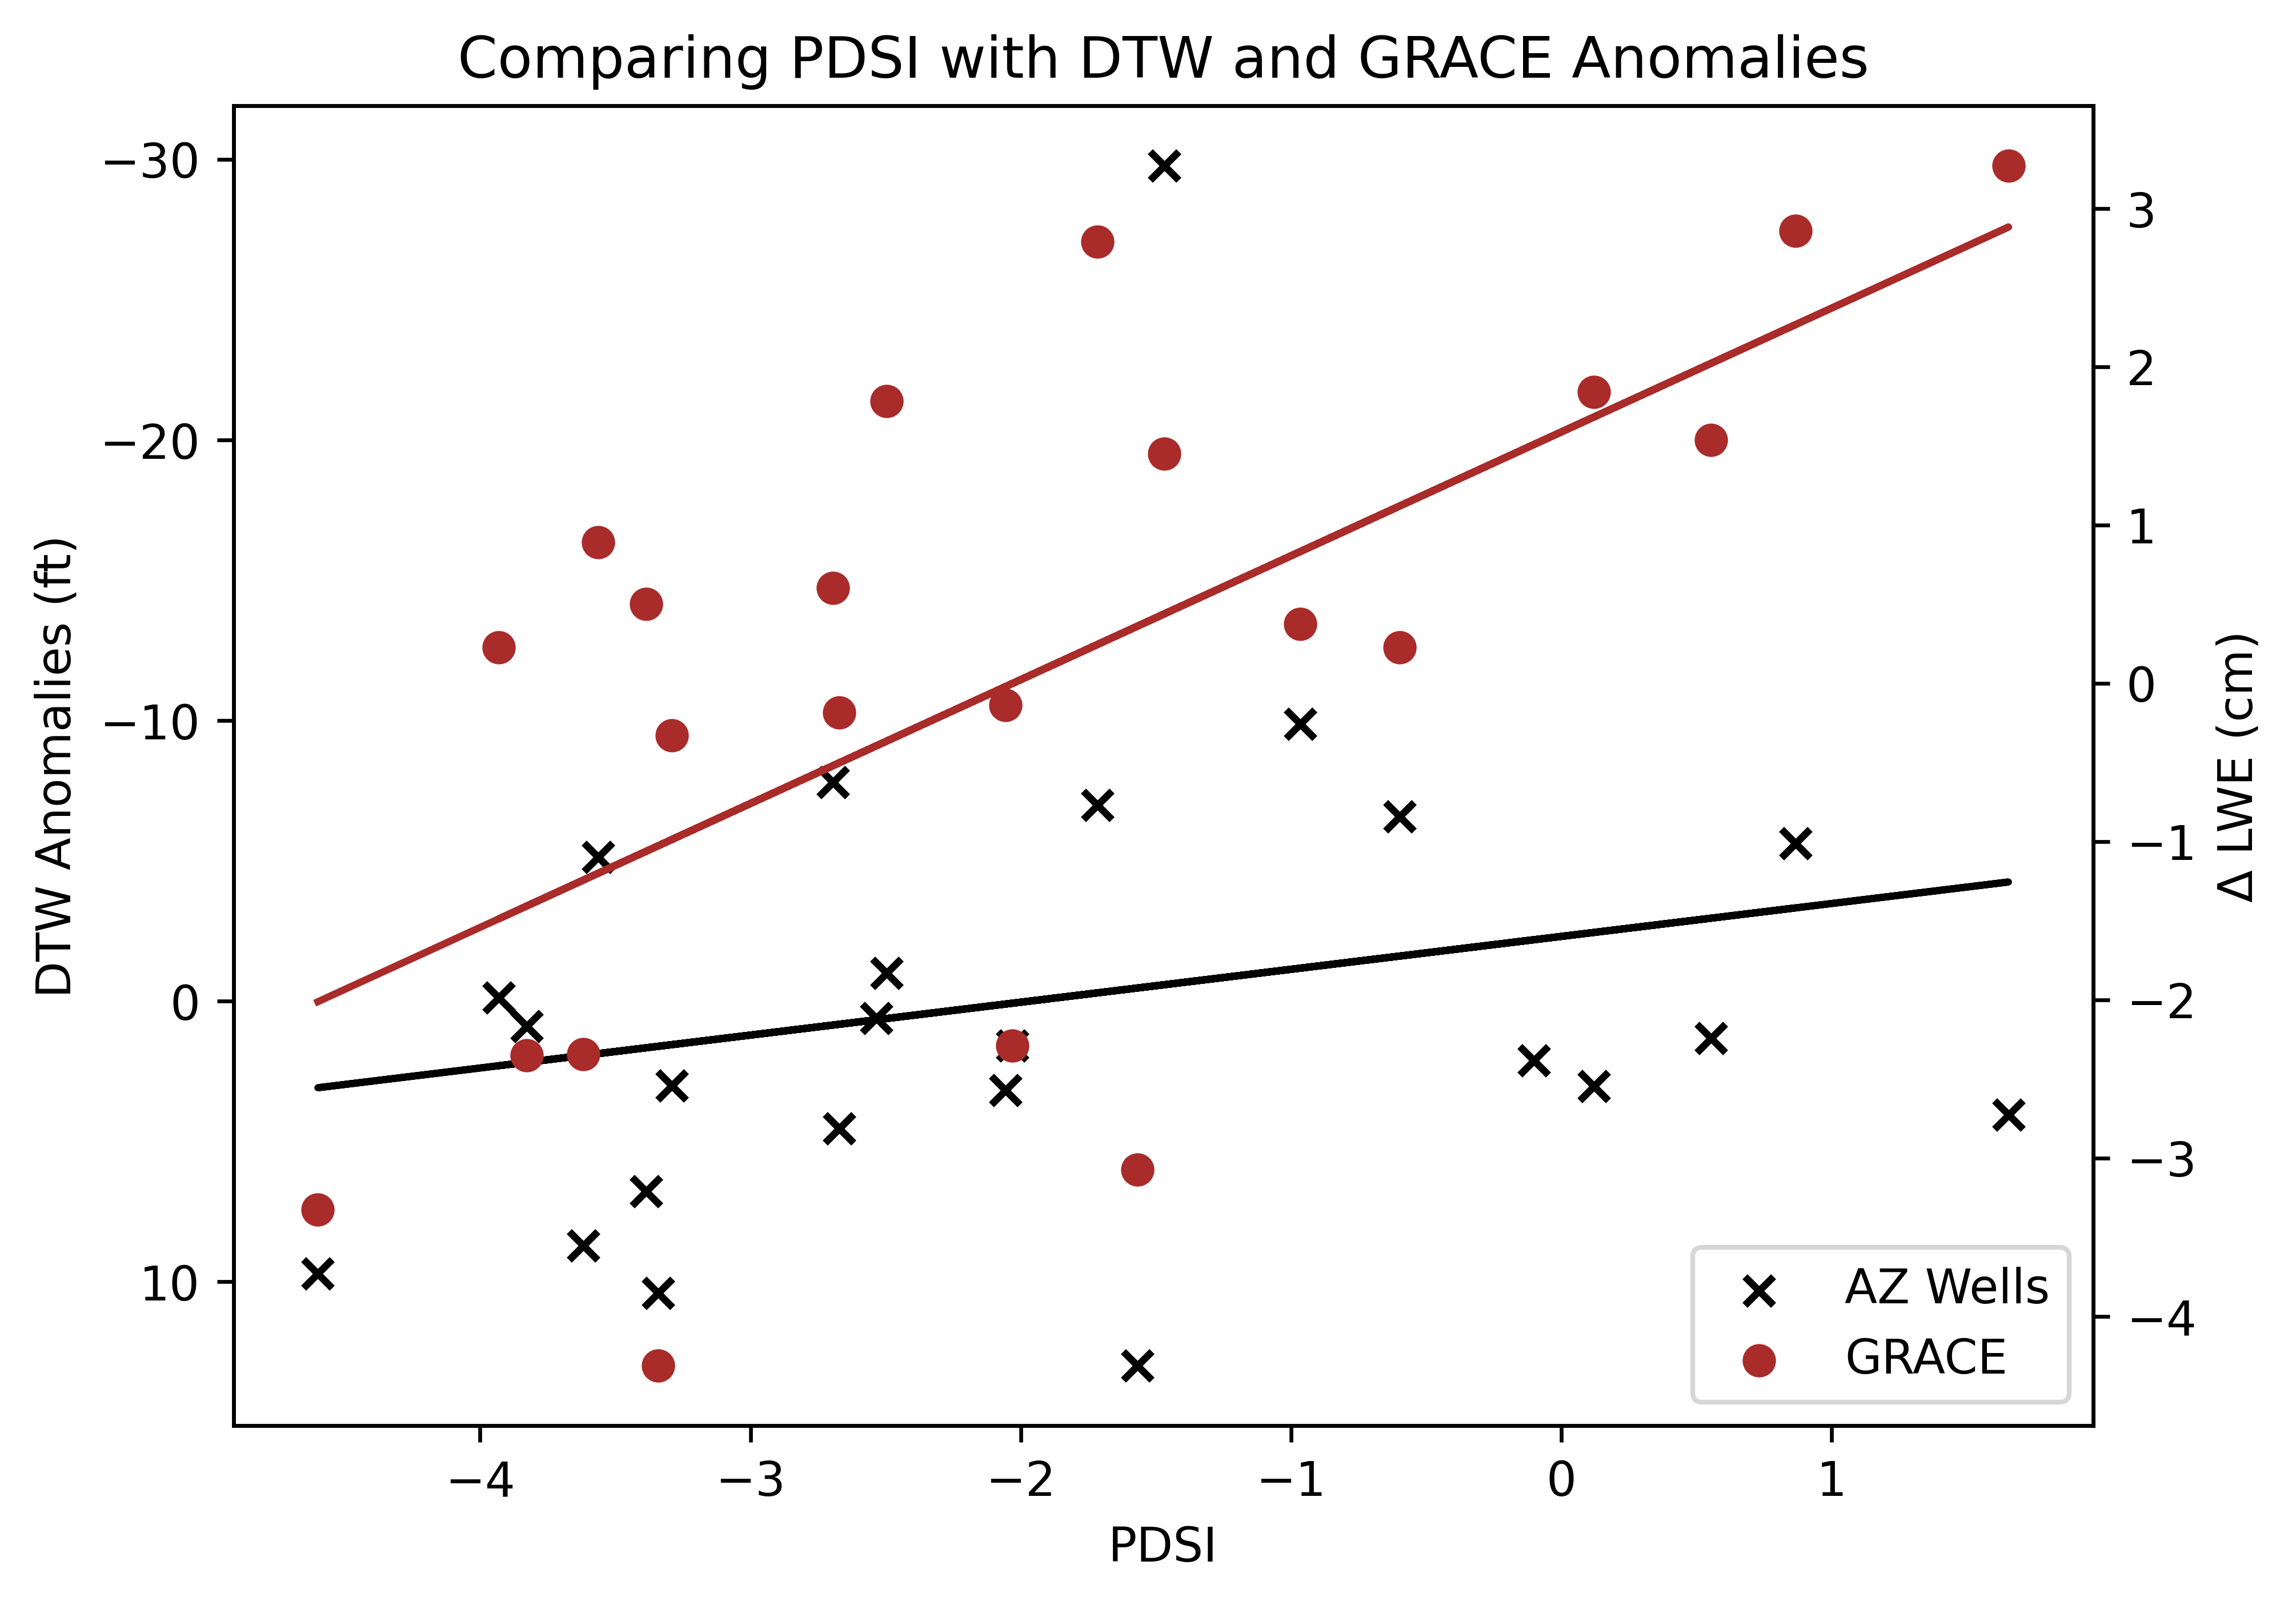

In [100]:
# %% Scatterplot of correlation values
ds = dtw_anomalys_grace
ds2 = dtw_anomalys_AZ
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE Anomalies'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
# ax.set_ylim(250,150)
# ax2.set_ylim(-15,5)
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW Anomalies (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

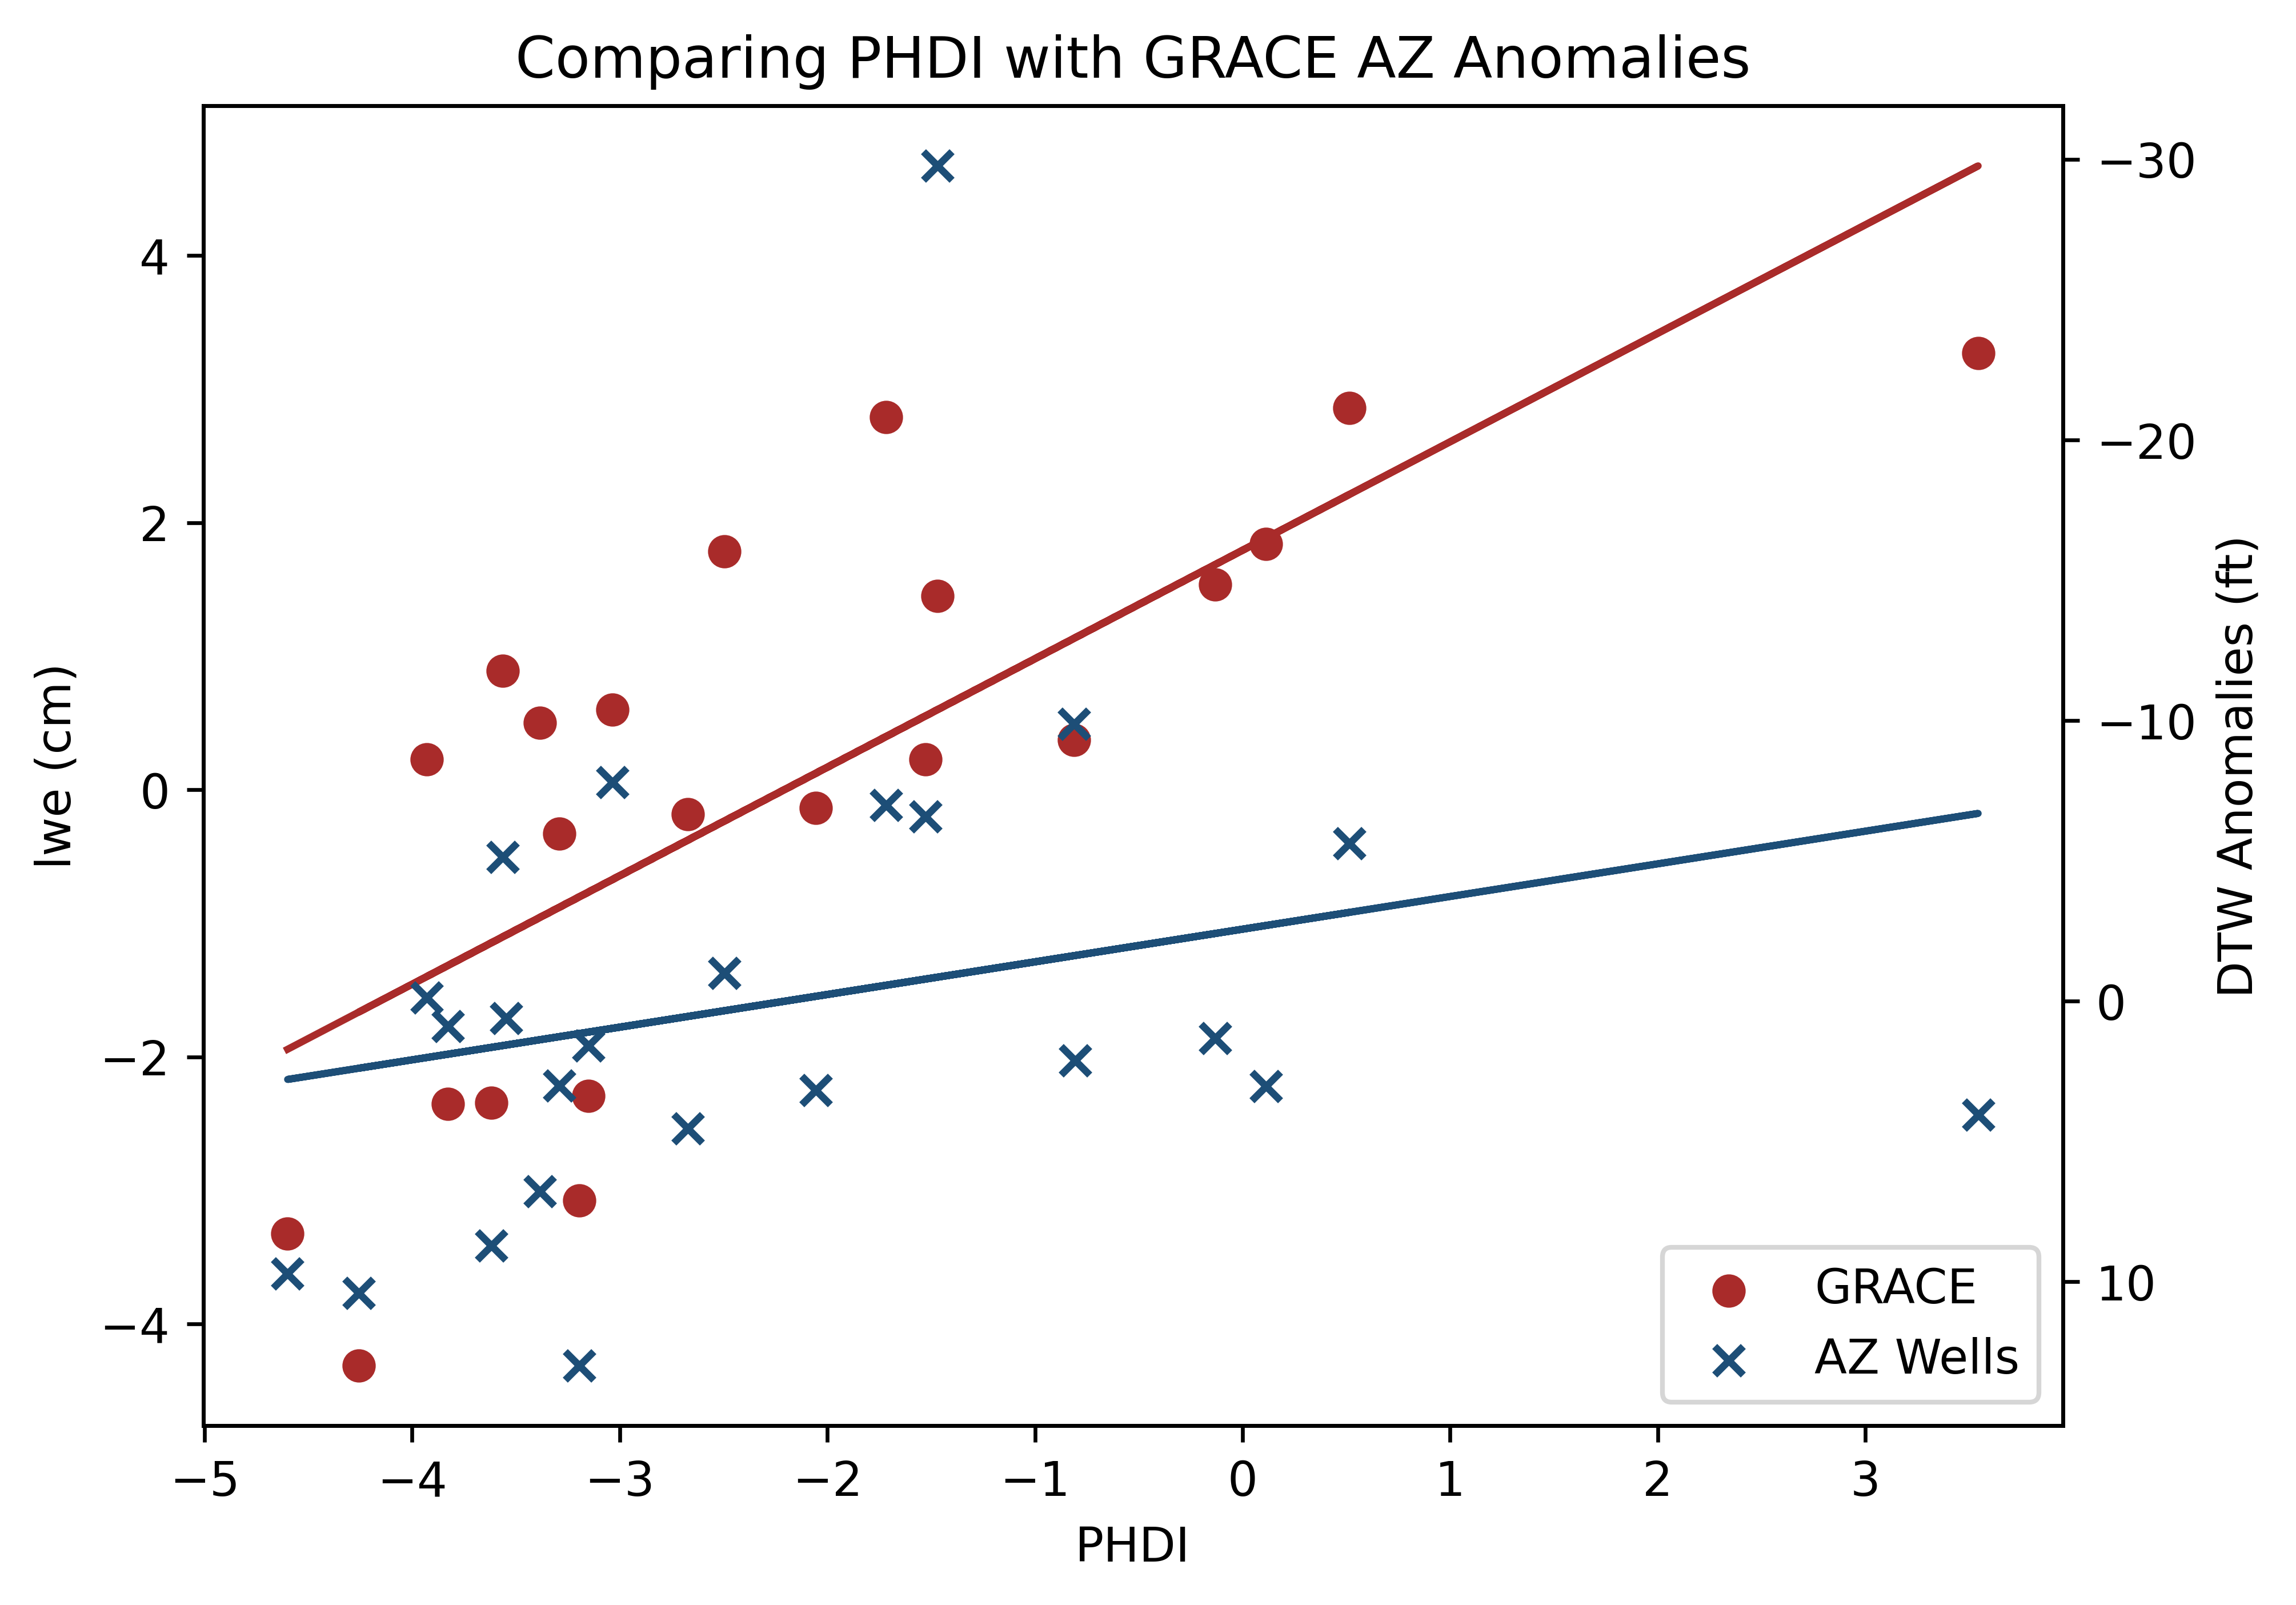

<Figure size 640x480 with 0 Axes>

In [78]:
# Doing this for PHDI
indice = 'PHDI'
# %% Scatterplot of correlation values

ds = dtw_anomalys_grace
ds2 = dtw_anomalys_AZ
ds2.columns = ds.columns
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()

# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with GRACE AZ Anomalies'

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Create a secondary y-axis
ax2 = ax.twinx()

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax2.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax2.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Reverse the order of the secondary y-axis
ax2.set_ylim(ax2.get_ylim()[::-1])

ax.set_xlabel(indice)
ax.set_ylabel('lwe (cm)')
ax2.set_ylabel('DTW Anomalies (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

plt.savefig(outputpath+name, bbox_inches='tight') 

Creating a timeseries plot of anomalies

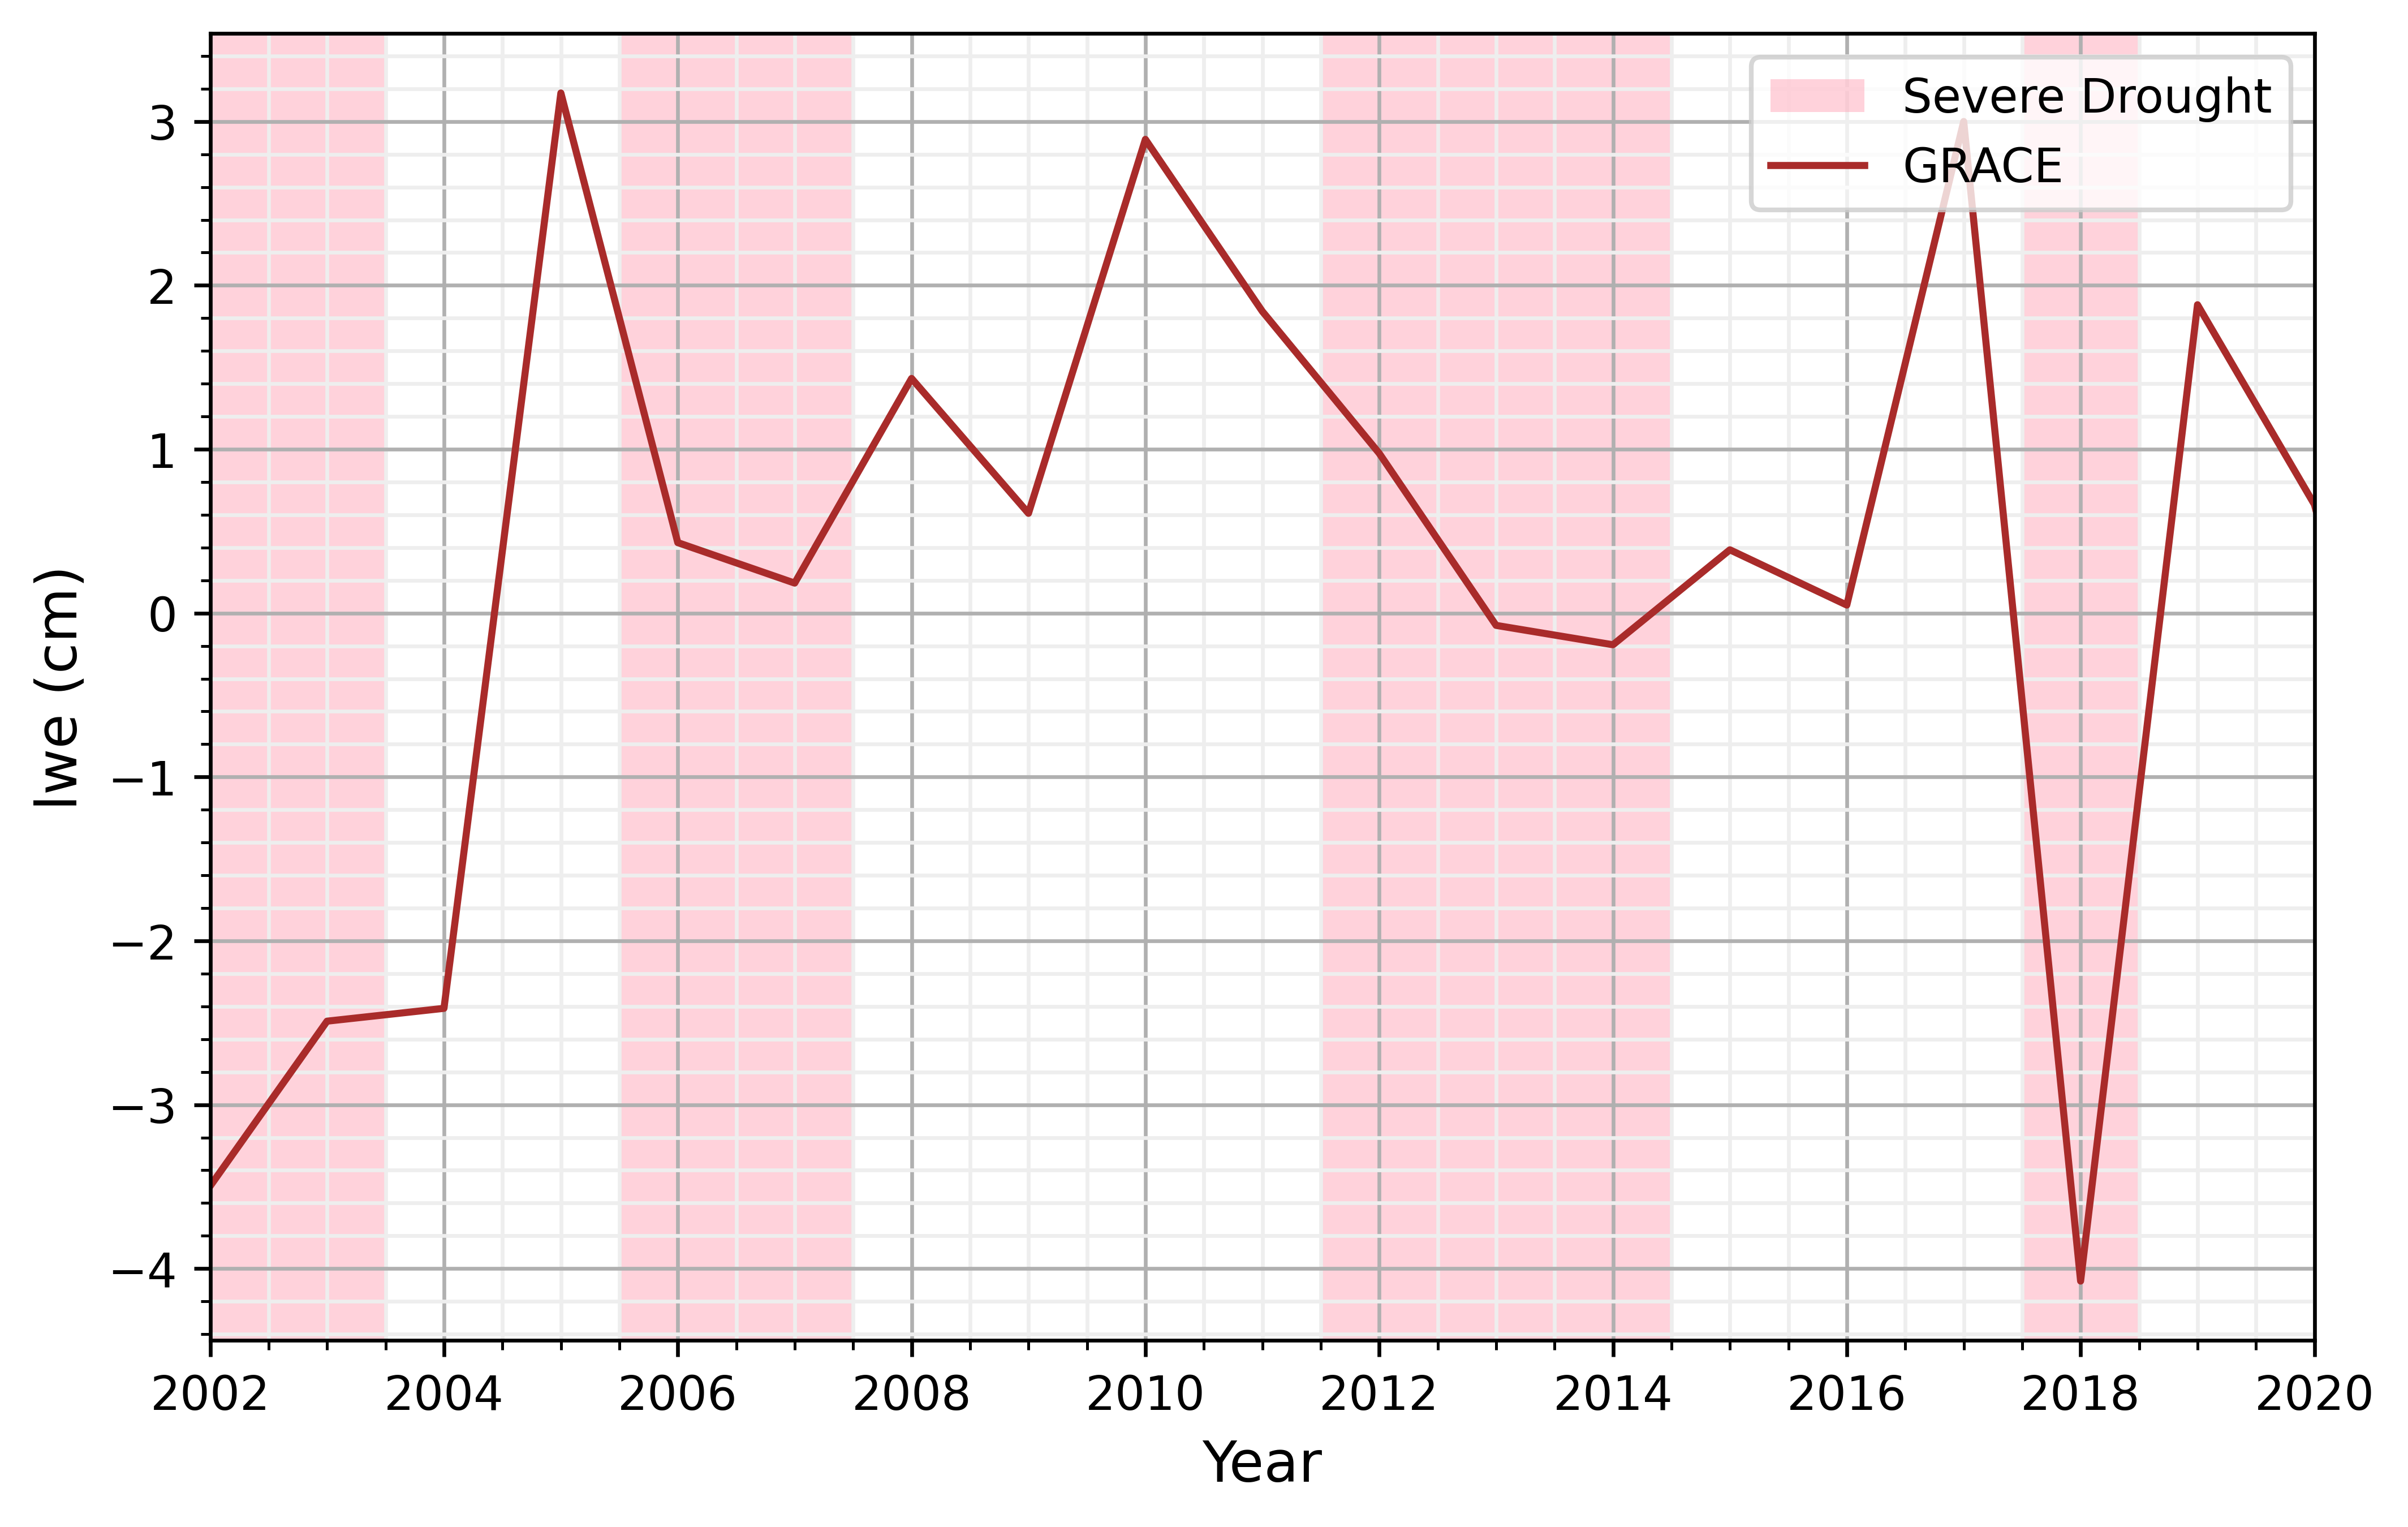

In [ ]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2002
mx_yr = 2020

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = 75
max_y = 300
fsize = 12

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
# e = 1999.5
# f = 2000.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
# plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds['0'], label='GRACE', color=grace_color) 

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('lwe (cm)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

# plt.savefig(figurepath+'Timeseries of DTW AZ Specific Anomalies', bbox_inches = 'tight')

In [ ]:
dtw_anomalys['0']

year
2002   -3.496623
2003   -2.490060
2004   -2.411852
2005    3.173948
2006    0.430191
2007    0.183082
2008    1.431911
2009    0.608843
2010    2.890826
2011    1.841745
2012    0.975275
2013   -0.074876
2014   -0.193226
2015    0.386286
2016    0.049020
2017    2.999859
2018   -4.076158
2019    1.881735
2020    0.662598
2021   -2.036531
2022   -2.735993
Name: 0, dtype: float64

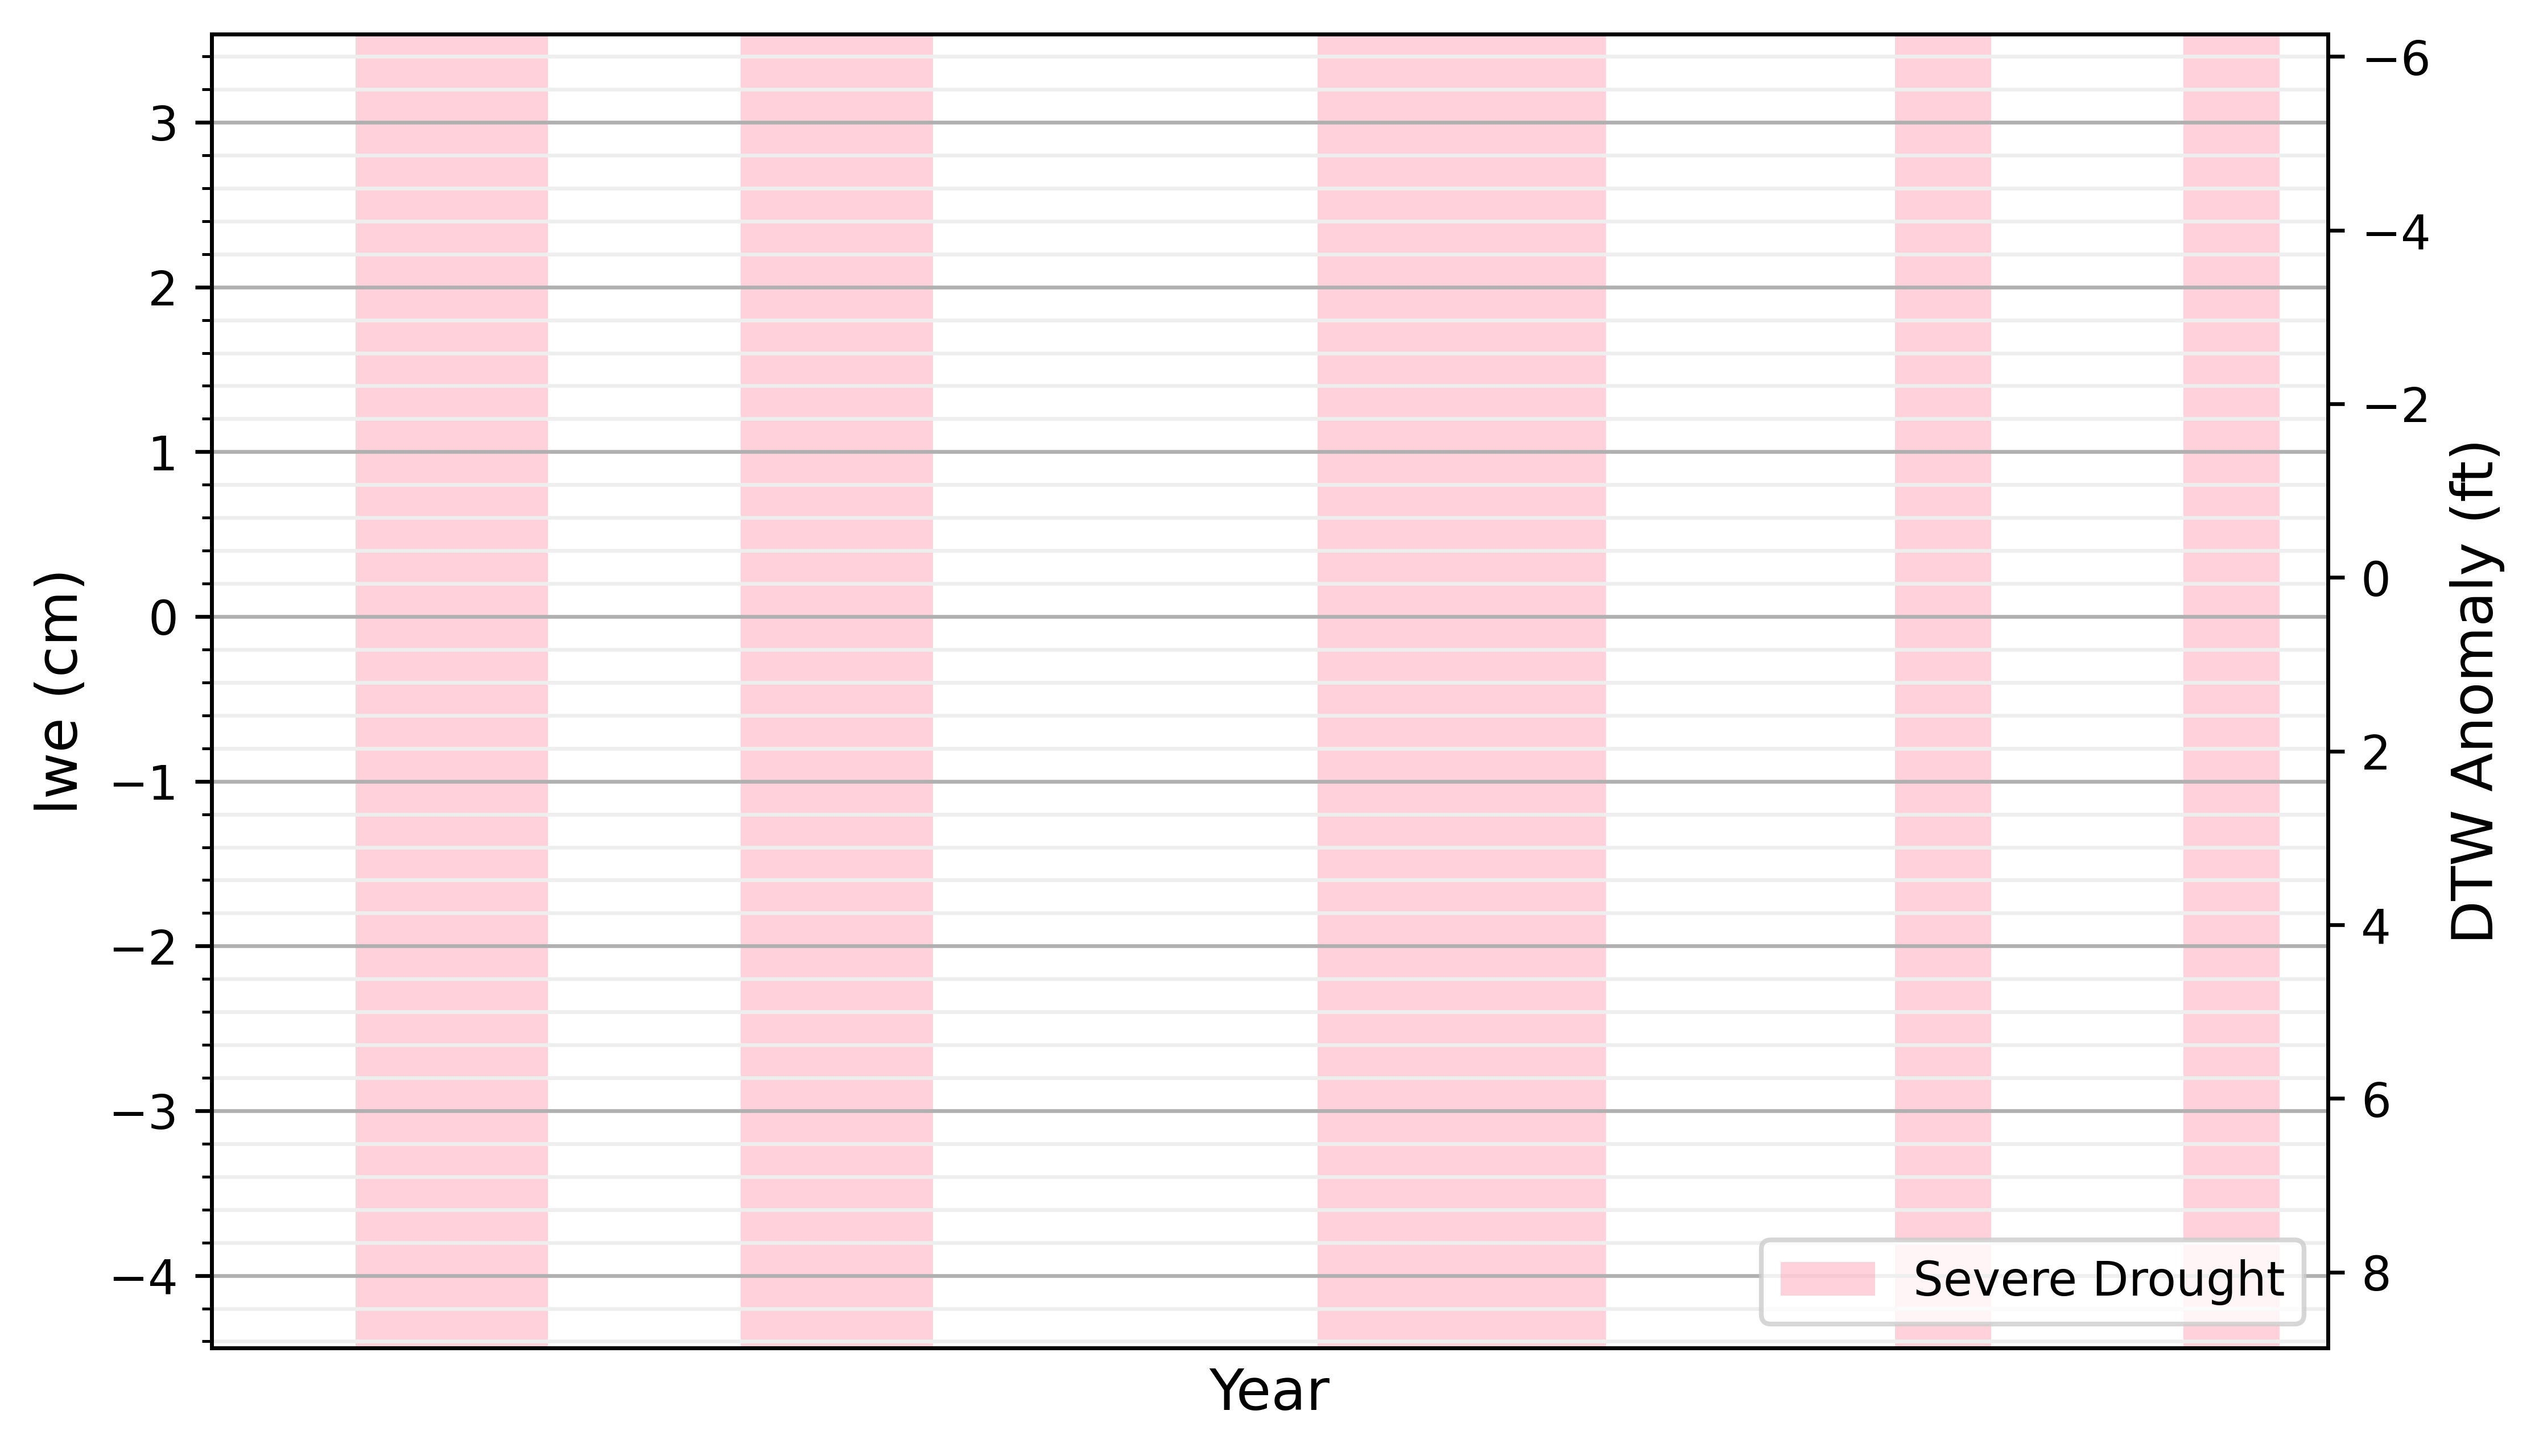

In [ ]:
# For both GRACE and AZ Wells
ds = dtw_anomalys_grace

# Convert the x-axis to datetime format for both datasets
ds.index = pd.to_datetime(ds.index)
dtw_anomalys_AZ.index = pd.to_datetime(dtw_anomalys_AZ.index)

min_yr = 2000
mx_yr = 2022

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = 75
max_y = 300
fsize = 12

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
e = 2020.5
f = 2021.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

# Plotting GRACE
ax.plot(ds['0'], 
        # label='GRACE', 
        color='#A92B2A') 

# Set the date formatter for the x-axis ticks
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)

# Set the interval for major ticks to 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('lwe (cm)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
# ax.legend(loc='upper right')

# Plotting AZ on a secondary axis
ax2 = ax.twinx()
ax2.plot(dtw_anomalys_AZ[0], 
        #  label='AZ Wells', 
         color='black',zorder=1)
# Set the date formatter for the x-axis ticks in the second subplot
ax2.xaxis.set_major_formatter(date_format)

# Set the interval for major ticks to 1 year
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
ax2.set_ylim(ax2.get_ylim()[::-1])
# ax2.set_ylim([15, -15])
ax2.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax2.legend(loc='lower right')

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

# plt.savefig(figurepath+'Timeseries of DTW AZ Specific Anomalies', bbox_inches = 'tight')

In [ ]:
# %% Average Anomaly for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_mean_anomalies = ds.groupby(['Status']).mean()
dtw_mean_anomalies
# ds

KeyError: "None of [Int64Index([2002, 2003], dtype='int64', name='year')] are in the [index]"

In [ ]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Average GRACE Anomalies by Drought Period'
# name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = [
        # "1989-1990",
        # '1996',
        '2002-2003',
        '2006-2007',
        '2012-2014',
        '2018',
        '2021',
        'Normal/Wet Years']

dtw_mean_anomalies.index = yearlabels
dtw_mean_anomalies = dtw_mean_anomalies.transpose()

dtw_mean_anomalies.index = betterlabels
del dtw_mean_anomalies['Normal/Wet Years']
dtw_mean_anomalies = dtw_mean_anomalies.transpose()


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_mean_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

# plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

AttributeError: 'DataFrame' object has no attribute '_convert'

For Max Drawdown

In [ ]:
# %% Max drawdown
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


drought_max = ds.groupby(['Status']).max()
drought_max

# ds

,0
Status,
Drought 3,-1.989978
Drought 4,0.621912
Drought 5,0.596740
Drought 6,-5.201791
Normal-Wet,3.468227


In [ ]:
# %% Max drawdown
ds = dtw_anomalys_AZ.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


drought_max = ds.groupby(['Status']).max()
drought_max

# ds

,0
Status,
Drought 3,1.854566
Drought 4,7.844184
Drought 5,0.000284
Drought 6,1.341230
Drought 7,7.440601
Normal-Wet,3.042029


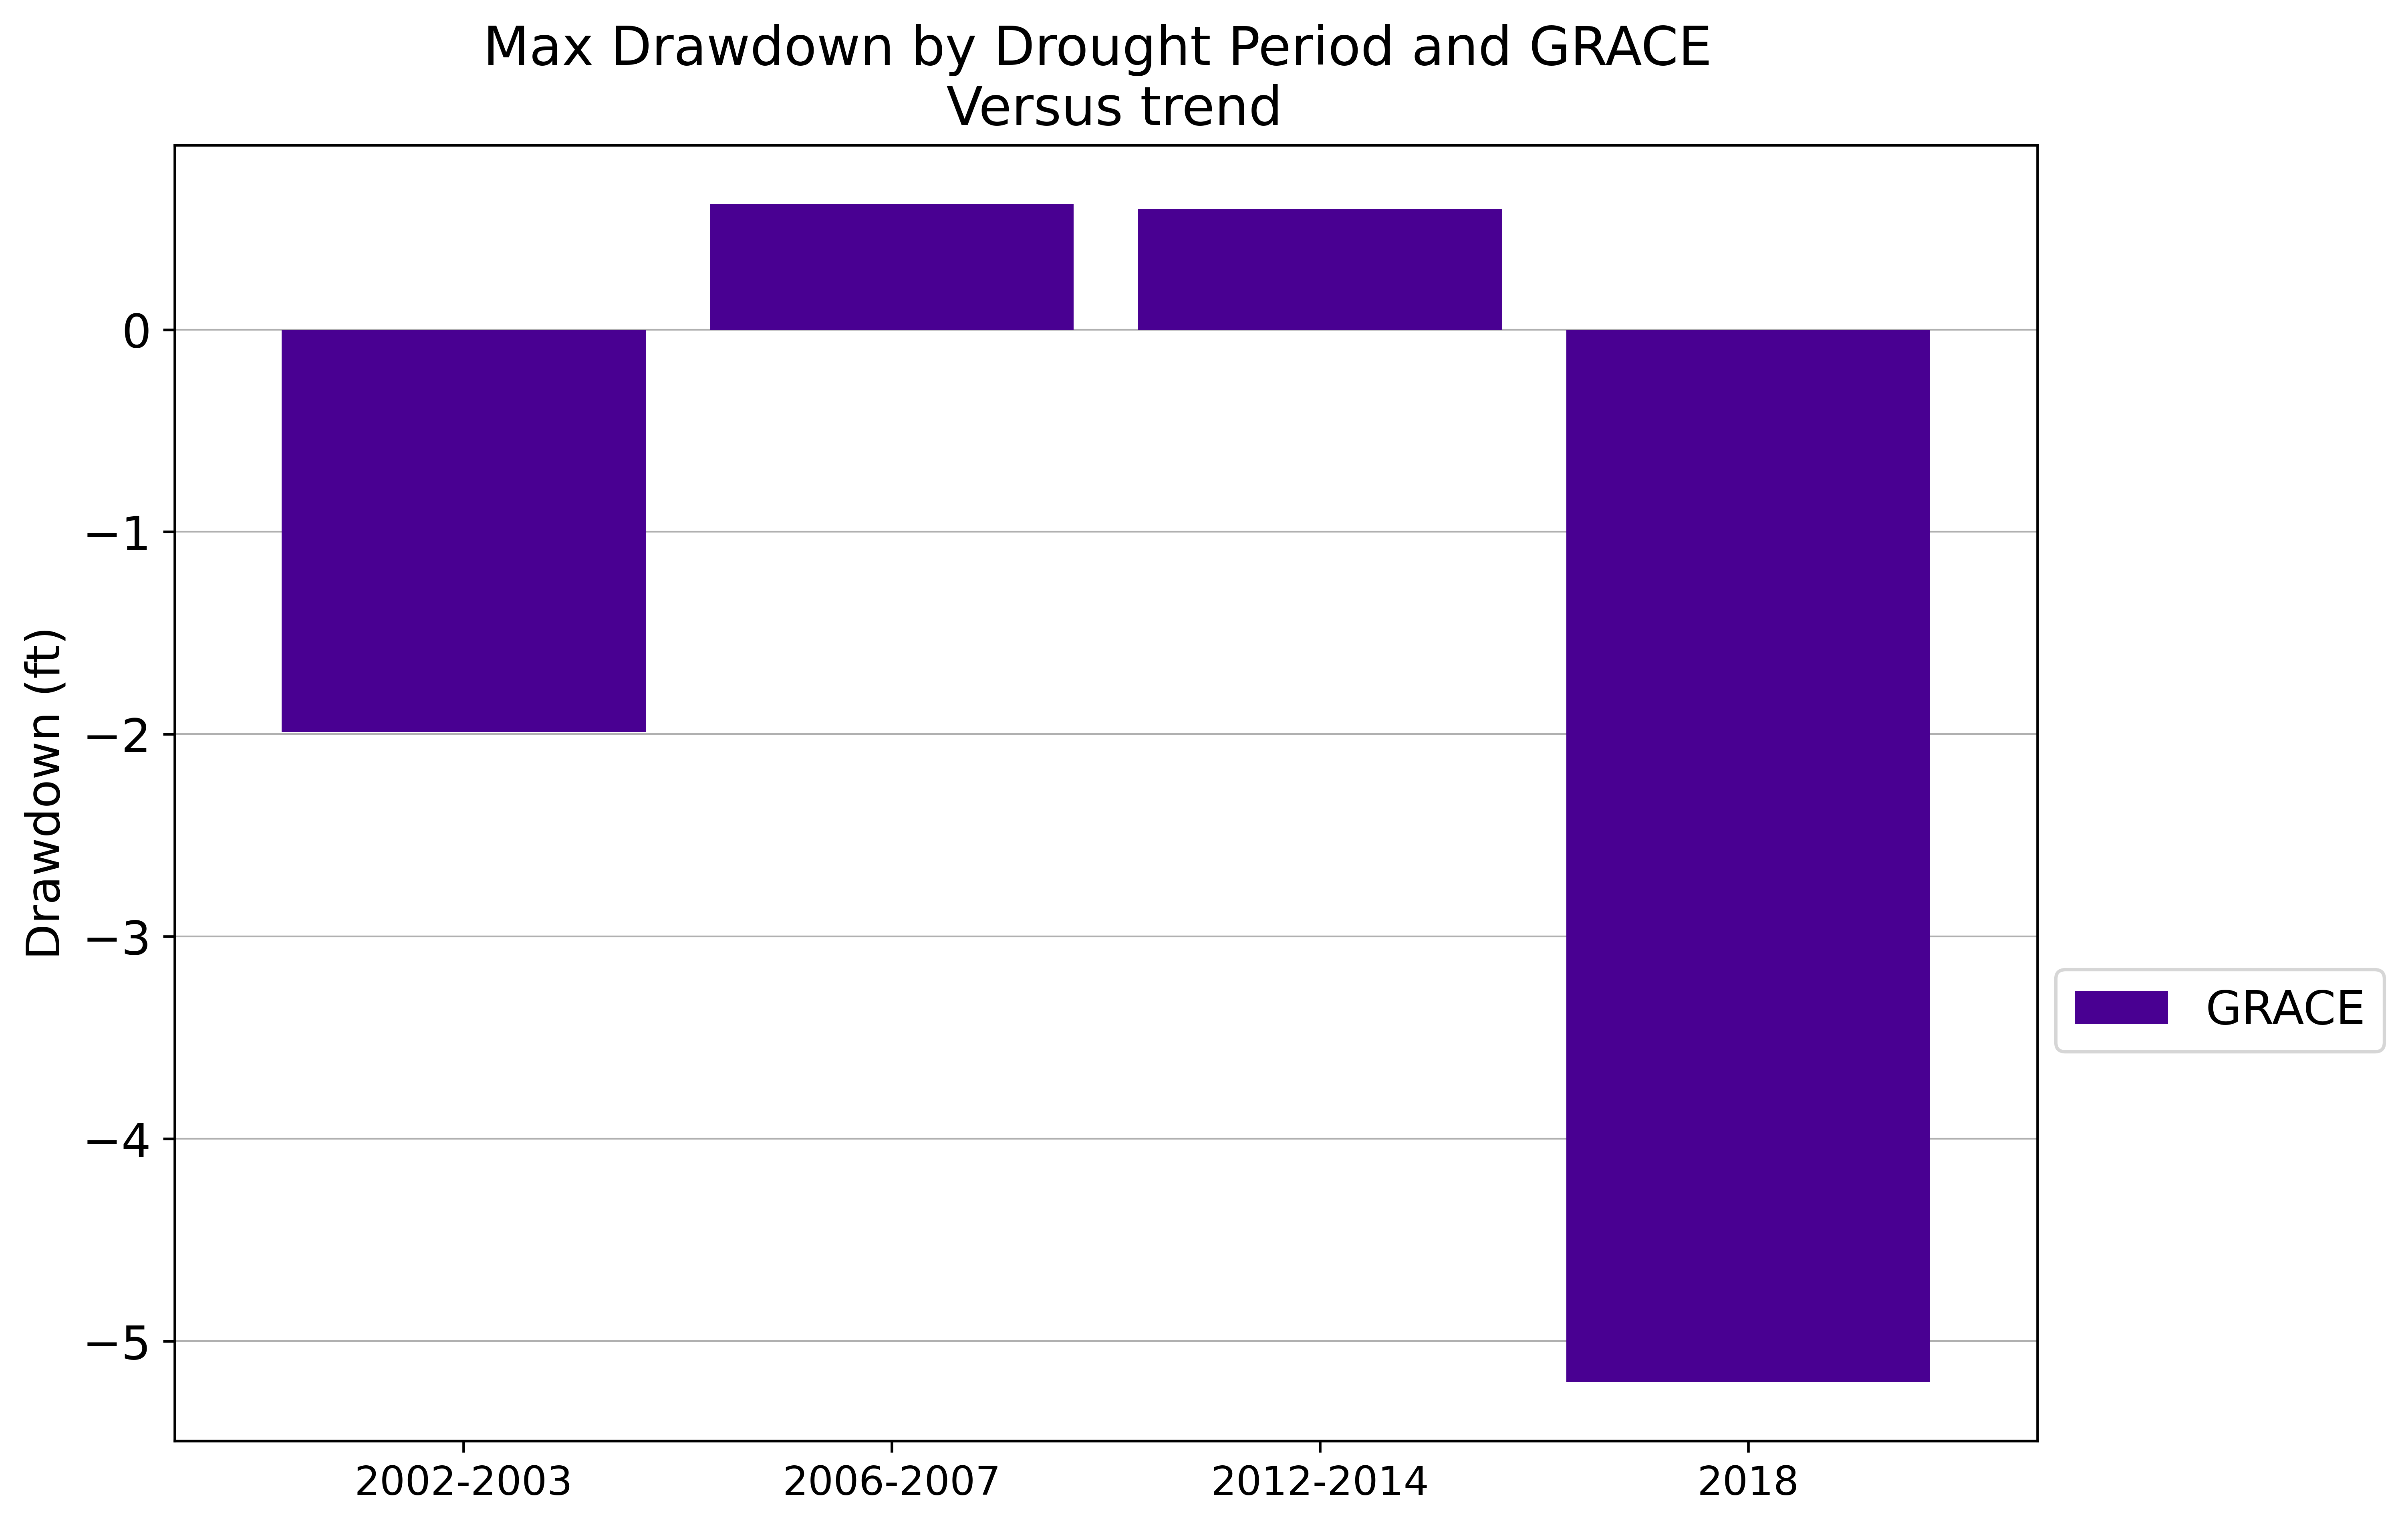

In [ ]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and GRACE \n Versus trend'
# name = 'Max Drawdown by Drought Period and Access to SW'

drought_max.index = yearlabels
drought_max = drought_max.transpose()
drought_max
drought_max.index = betterlabels
del drought_max['Normal/Wet Years']
drought_max = drought_max.transpose()

# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
drought_max.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

# plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')